In [24]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings

### Simple fully connected model for MNIST

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')
args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor()
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [3]:
train_model = False
if train_model:
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

### Load the model for investigation

In [81]:
def load_model(filename: str, test: bool=False):
    """ 
    load the model from the .pt file and evaluate on the test set if requested
    :param filename: str of model save filename
    :param test: bool dictating if the model is tested
    :return: loaded model
    """
    modeldict = torch.load(filename)
    model = Net()
    model.load_state_dict(modeldict)
    if test:
        test(model, device, test_loader)
    return model

In [5]:
# input, clas = next(iter(test_loader))

Waarde van 'pixel' fluctueren van 0 naar 1 en kijken wat het effect is op de output van het model

Mogelijke richtingen: r as, r random, r gradient

Gradient: ipv loss.backward kan je y.backward of je hebt w.grad en x.grad (misschien met x.requiresGradient=True). \\

Torch sequential: hooks/forward hook. layer.addForwardHook(x,... lambda x: )\\

Ook backward hook voor de gradient. 

### Run the modulated input through the model and save outputs

In [85]:
def direction(method: str, input: torch.Tensor, grad: torch.Tensor=None):
    """
    calculate the direction of a step given the requested direction type and the input
    :param method: string defining the method for calculating the direction ('axis', 'random' or 'gradient')
    :param input: input to the layer to be investigated
    :return: tensor array with the same shape as the input describing the direction
    """
    dir = torch.ones_like(input)
    match method:
        case 'axis':
            dir = torch.zeros_like(dir)
            dir = random_axis(dir)
        case 'random':
            dir = torch.rand_like(dir)
        case 'gradient':
            dir = grad.T@torch.ones(grad.shape[0])
        case _:
            warnings.warn('Unknown direction type, using all directions', RuntimeWarning)
            pass
    return dir

def random_axis(tensor: torch.Tensor): 
    """
    set a random value in an input-shaped tensor of zeros to 1, dictating a random direction along the axis to take the steps in
    :param tensor: input-shaped tensor of zeros
    :return: tensor of zeros and a 1
    """
    input_length = len(tensor.flatten())

    random_numbers = np.array(random.sample(range(0, input_length), input_length))
    random_numbers = random_numbers.reshape(np.array(tensor).shape)

    random_index = random.sample(range(0, input_length), 1)
    random_index = np.where(random_numbers == random_index)
    
    tensor[random_index] = 1
    return tensor

In [56]:
def forward_runs(input: torch.Tensor, model, dirtype: str=None):
    """
    run through the model while creating inputs at the different steps with the given direction. save the outputs for further inspection
    :param input: tensor input to the first layer
    :param model: neural network 
    :param dirtype: string describing the method used to find a direction
    :return: inputs into each layer with step adjustments, corresponding outputs, dirs, steps and grads
    """
    steps = np.logspace(-5,-1,5)
    input = torch.flatten(input)
    inputs = []
    outputs = []
    dirs = []
    grads = []

    for layer in model.model:
        layerinputs = [input.detach().clone()]
        layeroutputs = []

        input.requires_grad = True
        output = layer(input)
        grad = torch.autograd.functional.jacobian(layer, input)
        layeroutputs.append(output.detach().clone())
        
        dir = direction(dirtype, input, grad)
        for step in steps:
            newinput = input + step*dir
            newoutput = layer(newinput)
            layerinputs.append(newinput.detach().clone())
            layeroutputs.append(newoutput.detach().clone())

        inputs.append(layerinputs)
        outputs.append(layeroutputs)
        dirs.append(dir)
        grads.append(grad)

        input = output
        input = input.detach()
    return inputs, outputs, dirs, steps, grads

In [8]:
# inputs, outputs, dirs, steps, grads = forward_runs(input[0], model)

f(x+ar) = f(x) + arf'(x)

En checken of dit binnen threshold blijft.

In [65]:
def calc_exp_act(inputs: list, outputs: list, dirs: list, steps: list, model, grads: list):
    """ 
    calculate the expected outputs assuming linearity, and take the actual outputs from the model
    :param inputs: list of lists containing model inputs at different layers and steps
    :param outputs: list of lists containing model outputs
    :param dirs: list of lists containing directions
    :param steps: list of step sizes
    :param model: neural network
    :param grads: list of lists containing gradients
    :return: expected outputs assuming linearity and actual outputs
    """
    expected_outputs = []
    actual_outputs = []
    for i, layer in enumerate(model.model):
        layerinput = inputs[i]
        layeroutput = outputs[i]
        layerdir = dirs[i]
        layergrad = grads[i]

        input0 = layerinput[0]
        output0 = layeroutput[0]
        exp_layer_outputs = []
        act_layer_outputs = []

        for i, step in enumerate(steps):
            stepinput = layerinput[i+1]
            stepoutput = layeroutput[i+1]
            expected_linear_output = output0 + step*np.matmul(layergrad,layerdir)
            actual_output = stepoutput
            exp_layer_outputs.append(expected_linear_output)
            act_layer_outputs.append(actual_output)
        
        expected_outputs.append(exp_layer_outputs)
        actual_outputs.append(act_layer_outputs)
    return expected_outputs, actual_outputs

# exp, act = calc_exp_act(inputs, outputs, dirs, steps, model, grads)

In [22]:
def calc_linearity(exp: list, act: list, model, steps: list):
    """ 
    calculate the linearity by finding the norm of the difference matrix
    :param exp: list of lists containing expected outputs
    :param act: list of lists containing actual outputs
    :param model: neural network
    :param steps: list of step sizes
    :return: list of norms for each layer and step size
    """
    norms = []
    for i, layer in enumerate(model.model):
        layernorm = []
        expected = exp[i]
        actual = act[i]
        for i, step in enumerate(steps):
            diff = expected[i] - actual[i]
            norm = np.linalg.norm(diff)
            layernorm.append(norm)
        norms.append(layernorm)
    return norms
        
# norms = calc_linearity(exp, act, model, steps)

In [82]:
def plot(model, steps: list, norms: list):
    """ 
    plot the L2 norms per step size for each layer in the model
    :param model: model to be investigated
    :param steps: list of step sizes
    :param norms: list of norms per layer and step size
    """
    fig, axs = plt.subplots(2, 1, layout='constrained', figsize=(7,7))
    for i, layer in enumerate(model.model):
        if f'{layer}' == 'ReLU()':
            j = 1
        else:
            j = 0
        axs[j].plot(steps, norms[i], label=f'{i+1}: {layer}')
    # axs[0].set_ylim(0,9*10**-6)
    # axs[1].set_ylim(0,0.3)
    for ax in axs:
        ax.set_xscale('log')
        ax.legend()
        ax.set_ylabel('$L_{2,2}$ norm')
        ax.set_xlabel('Step size')

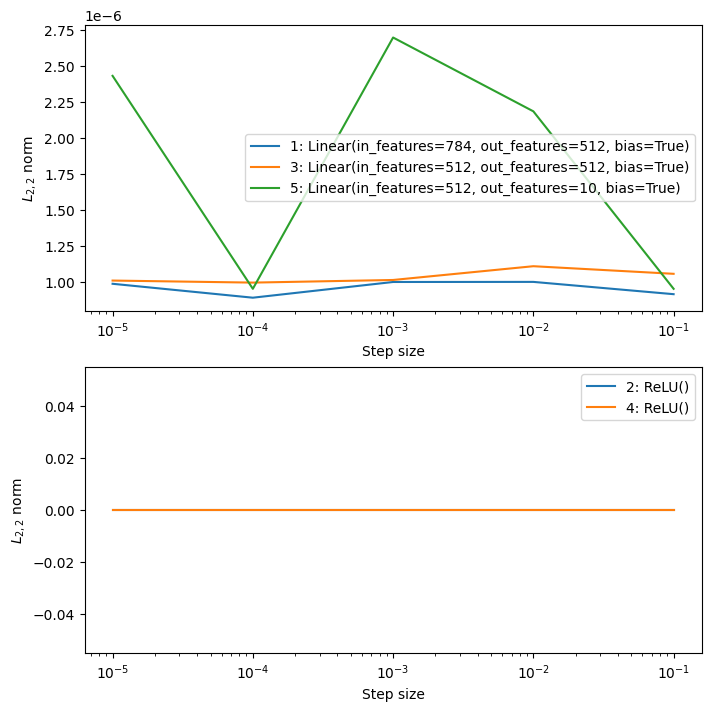

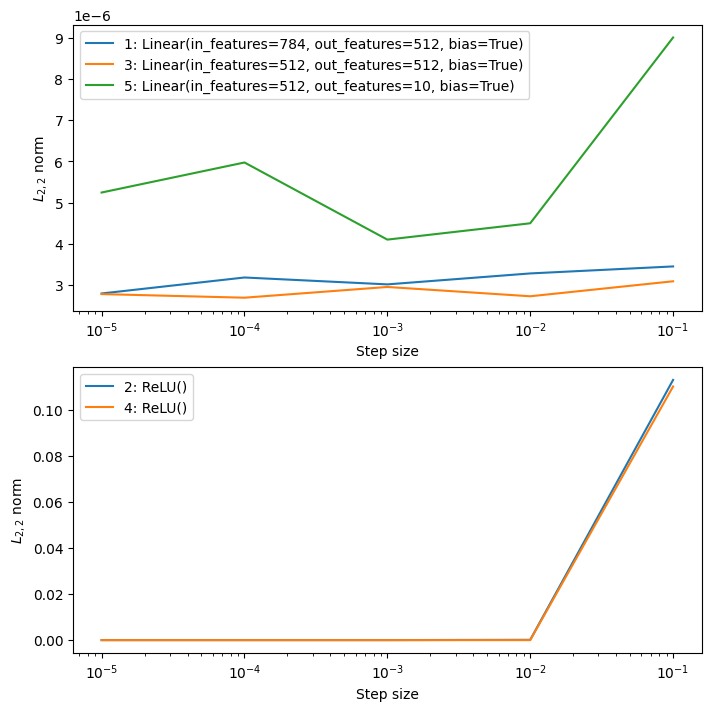

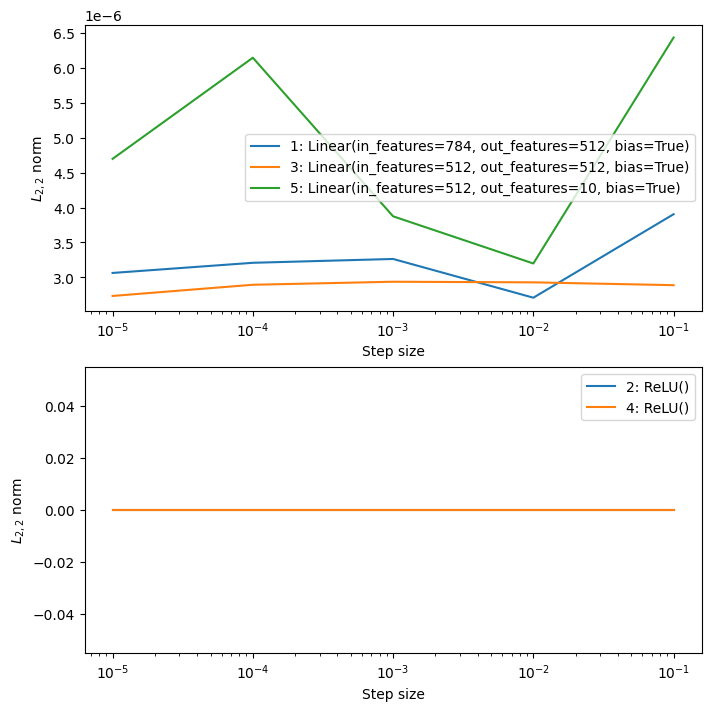

In [86]:
def pipeline(model_name: str, dir: str, test_loader=test_loader):
    """
    calculate linearity per layer given a model and test loader, and plot the results
    :param model_name: string of model save filename
    :param test_loader: test data loader
    """
    model = load_model(model_name)
    input = next(iter(test_loader))[0]
    inputs, outputs, dirs, steps, grads = forward_runs(input[0], model, dir)
    exp, act = calc_exp_act(inputs, outputs, dirs, steps, model, grads)
    norms = calc_linearity(exp, act, model, steps)
    plot(model, steps, norms)

pipeline('mnist_cnn.pt', 'axis')
pipeline('mnist_cnn.pt', 'random')
pipeline('mnist_cnn.pt', 'gradient')

### Using hooks

In [ ]:
def input_output_hook(self, module, input, output):
    self.input = input
    self.output = output

def gradient_hook(self, module, input: torch.tensor, output: torch.tensor):
    output.backward()